In [1]:
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
torch.autograd.set_detect_anomaly(True)
import websocket, json, pprint, talib, numpy
import websockets
from binance.client import Client
from binance.enums import *
import joblib
import robin_stocks as rs
import config
import asyncio
import nest_asyncio
import time

In [2]:
rs.robinhood.login(username= config.RH_USER, password= config.RH_PASS, expiresIn=86400, by_sms=True)

{'access_token': 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiJ9.eyJleHAiOjE2NTI4MjQ0MTIsInRva2VuIjoiSVZVMXluUXBHa28xa3dRT3J3ZlVmenFQcHp0NloyIiwidXNlcl9pZCI6Ijk1MmFhMzljLTBhMjQtNDliMS05MjQ0LWE2NmM0ZTYzZDQzOCIsImRldmljZV9oYXNoIjoiNzZkMTM3YmU4YzExYTY1OTA4YjViNDIyOTkyMmYzZGIiLCJzY29wZSI6ImludGVybmFsIiwiZGN0IjoxNjUyMTIxMTM2LCJzZXJ2aWNlX3JlY29yZHMiOlt7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJudW1tdXNfdXMiLCJzaGFyZF9pZCI6MSwic3RhdGUiOiJhdmFpbGFibGUifSx7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJicm9rZWJhY2tfdXMiLCJzaGFyZF9pZCI6Niwic3RhdGUiOiJhdmFpbGFibGUifV0sInVzZXJfb3JpZ2luIjoiVVMiLCJvcHRpb25zIjp0cnVlLCJsZXZlbDJfYWNjZXNzIjpmYWxzZX0.KuT4wFtndQo_p50zmGwAxFQ4er6pK1jmrf1IAzG_oMW_dxF9WyWr2JINOVafB5GzDL0C1R-YDnhV3jiHcdcByG5agKIrk-rsIryczLUSvnWQUxHKVI6Cs5m9ZFGNCvFnyHkbKGIbGvh63Q_TqT-Hvb2i23dSjJ-B8fDzjzDhpInJmxTriAVVCxroJ1xygbVNDg9vODBSctX9NwaF2UpAhdEyAbG4_KrMgRkzVhM3DG1ZicZVgSrRJqpVPmdVwYdhSw2JBOOresWAZZXfXgTYV6eCz91m2kffWgIimgKmxh_t6XWc_jOPEQMORKWGzaL_6dAGa2kU-o_RoULPJlFfKw',
 'token_type': 'Bearer',
 'expires_in': 8640

In [3]:
#rs.robinhood.order_buy_crypto_by_price('ETH', 1)

In [4]:
data = pd.read_csv('data_1m.csv')
data = data.iloc[:43301]
#labels = data.loc[:, "labels"]
close = data.loc[:, "closes"]
close = close.iloc[1:]
data = data.iloc[:-1]
data = data.drop(["labels"], axis=1)
data.head()

print(len(data), len(close))

43300 43300


In [5]:
data = data.to_numpy()
close = close.to_numpy()
#extra = np.shape(data)[0] % 32
#data = data[extra:, :]
data = torch.tensor(data)
data = data.to(torch.float)
#close = close[extra:]
close = torch.tensor(close)
close = close.to(torch.float)
data, X_test, close, y_test = train_test_split(data, close, test_size=0.5, shuffle = False)
print(len(data), len(X_test), len(close), len(y_test))
class Dataset():
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, idx):
        return self.array[idx, :], self.labels[idx]


21650 21650 21650 21650


In [6]:
batch_size = 1 
fulldata = Dataset(data, close)
dataloader = DataLoader(fulldata, batch_size)
loss_function = nn.MSELoss()

testdata = Dataset(X_test, y_test)
testdataloader = DataLoader(testdata, batch_size)

pred_array = np.zeros(len(data))

In [7]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, HL_size, num_layers = 1):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_size,
                                hidden_size=HL_size,
                                num_layers=num_layers)
        
        self.linear = torch.nn.Linear(HL_size , 12)
        self.linear2 = torch.nn.Linear(12, 1)
        self.num_layers = num_layers
        self.hidden_size = HL_size
        
    def forward(self, inputs, hidden):
        out, hidden = self.rnn(inputs, hidden)
        pred = self.linear(out)
        pred = self.linear2(pred)

        #hidden = hidden.view(-1, 1, self.hidden_size)
        return pred, hidden
    
    def init_hidden(self, batch = 1):
        hidden = torch.randn(self.num_layers, batch, self.hidden_size)
        return hidden

def rnn_train():
    model = RNNModel(np.shape(data)[1], HL_size = 24, num_layers = 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    hidden = model.init_hidden(batch_size)
    total_loss = 0
    for batch_idx, (batch, truth) in enumerate(dataloader):
        
        hidden = hidden.detach()

        batch = np.reshape(batch, (1, -1, 11))
        pred, hidden = model.forward(batch, hidden)

        pred = torch.squeeze(pred, 0)
        pred = torch.squeeze(pred, 1)
        #print(pred)
        pred_array[batch_idx] = pred.item()
        single_loss = loss_function(pred, truth)
        single_loss.backward(retain_graph=True)
        clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        optimizer.zero_grad()
        total_loss = total_loss + single_loss.item()
        if batch_idx % 100 == 0:
            print(batch_idx)
            print(total_loss)
            #print(hidden)
            total_loss = 0
            
    '''
    for name, param in model.named_parameters():
                if param.requires_grad:
                    print(name, param.data)
    '''
    return model, hidden
            
trained_model, final_hidden = rnn_train()

0
0.5983555912971497
100
4.344143165143464
200
0.6052161373738869
300
0.22576446624483992
400
0.2649395458666248
500
0.11689033813959782
600
0.4307086036901637
700
0.3789518561393592
800
0.0499004251414874
900
0.031575145093459156
1000
0.07094235827474904
1100
0.0675092809624438
1200
0.1652852408908707
1300
0.021280318533968057
1400
0.07588006058877639
1500
0.09945532948269431
1600
0.016821401917813006
1700
0.0505215152381453
1800
0.037967966888203364
1900
0.12260689835432359
2000
0.026924478824643217
2100
0.023683407243510146
2200
0.017365891438316794
2300
0.0102843431014783
2400
0.006615532045479711
2500
0.008750013195271578
2600
0.02058464883035427
2700
0.032256965718204356
2800
0.09861326678424476
2900
0.08189940166533916
3000
0.08974690740948077
3100
0.10098999069941783
3200
0.08067839295375734
3300
0.10829919219247586
3400
0.007288818303983646
3500
0.01503263232300256
3600
0.0073992972916983035
3700
0.11576204074033924
3800
0.06032598271307066
3900
0.08342698374549684
4000
0.0104

21650
21650
[ 0.31772636  0.31006629  0.30951032 ... -2.31900466 -2.31900466
 -2.31103572]
tensor([ 0.2743,  0.2743,  0.2743,  ..., -2.1924, -2.1924, -2.2014])


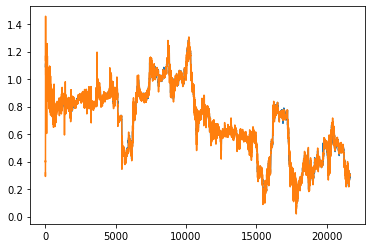

In [8]:
data2 = pd.read_csv('data_1m.csv')
data2 = data2.iloc[21350: 43000]
truth_array = data2.loc[:, "closes"].to_numpy()
close_numpy = close.numpy()
print(len(truth_array))
print(len(pred_array))
print(truth_array)
print(y_test)
plt.plot(close_numpy)
plt.plot(pred_array)
plt.show()

In [9]:
hidden = final_hidden
total_batches = 0
total_error = 0

#model = RNNModel(np.shape(data)[1], HL_size = 24, num_layers = 2)

optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.01)
    
for batch_idx, (batch, truth) in enumerate(testdataloader):
    optimizer.zero_grad()
    hidden = hidden.detach()
    batch = np.reshape(batch, (1, -1, 11))
    pred, hidden = trained_model.forward(batch, hidden)
    pred = torch.squeeze(pred, 0)
    pred = torch.squeeze(pred, 1)
    single_loss = loss_function(pred, truth)
    single_loss.backward(retain_graph=True)
    clip_grad_norm_(trained_model.parameters(), 5)
    optimizer.step()
    total_batches += 1
    if (pred < truth_array[batch_idx] and truth > truth_array[batch_idx]) or \
        (pred > truth_array[batch_idx] and truth < truth_array[batch_idx]):
            total_error +=1
    if batch_idx % 100 == 0:
            print(batch_idx)
                                                                 

        
print('######\n', total_error)
print(total_batches)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

## Live Prediction

In [10]:
SOCKET = "wss://stream.binance.com:9443/ws/ethusdt@kline_1m"
RSI_PERIOD = 14
in_position = False
client = Client(config.KEY, config.SECRET, tld='us')
scaler = joblib.load('standard_scaler_1m.save')

In [11]:
# import time
# currMilli = round(time.time() * 1000)
# currCandles = client.get_klines(symbol='ETHUSDT', 
#                                 interval=Client.KLINE_INTERVAL_1MINUTE, 
#                                 startTime = (currMilli - 900000), 
#                                 endTime = (currMilli),
#                                 limit = 14)

# #print(currCandles)


# opens = [float(c[1]) for c in currCandles]
# closes = [float(c[4]) for c in currCandles]
# volumes = [float(c[5]) for c in currCandles]
# highs = [float(c[2]) for c in currCandles]
# lows = [float(c[3]) for c in currCandles]
# qavs = [float(c[7]) for c in currCandles]
# numTrades = [float(c[8]) for c in currCandles]
# tbbavs = [float(c[9]) for c in currCandles]
# tbqavs = [float(c[10]) for c in currCandles]

# closes.reverse()
# volumes.reverse()

# rsis = []
# obvs = []
# scaled_df = None
# hidden_squeeze = torch.squeeze(hidden, 1)
# df_history = pd.DataFrame(data={"time": [], "opens": [], "highs": [], "lows": [], "closes": [], "volumes": [], "qavs": [], "numTrades": [], "tbbavs": [], "tbqavs": [], "rsis": [],"obvs": []})
# count = 0
# correct = 0
# boughtPrev = False
# closePrev = float(0)
# predPrev = float(0)
# money = float(0)


# async def on_message():
#     global hidden_squeeze, closePrev, boughtPrev, closes, in_position, opens, highs, lows, volumes, qavs, numTrades, tbbavs, tbqavs, rsis, obvs, df_history, money, count, correct
    
    
#     #print('CLOSES: ', len(closes), closes)
#     #print('received message')
#     json_message = json.loads(message)
#     #pprint.pprint(json_message)

#     candle = json_message['k']
 
#     is_candle_closed = candle['x']
#     close = float(candle['c'])
#     open_ = float(candle['o'])
#     high = float(candle['h'])
#     low = float(candle['l'])
#     vol = float(candle['v'])
#     qav = float(candle['q'])
#     numTrade = float(candle['n'])
#     tbbav = float(candle['V'])
#     tbqav = float(candle['Q'])
#     time = candle['t']

#     if is_candle_closed:
#         print("candle closed at {}".format(close))
#         closes.insert(0, close)
#         volumes.insert(0, vol)
#         opens.append(float(open_))
#         highs.append(float(high))
#         lows.append(float(low))
#         qavs.append(float(qav))
#         numTrades.append(float(numTrade))
#         tbbavs.append(float(tbbav))
#         tbqavs.append(float(tbqav))
        
# #         if(predPrev != float(0)):
# #             df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [1],"obvs": [1]})
# #             scaled_df = scaler.transform(df)
# #             scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
# #             data = scaled_df.to_numpy()
# #             truePred = data[0][3]
# #             print("\nBack Propogate... \n")
                                  
# #             predPrev =  torch.squeeze(predPrev, 1)
# #             predPrev =  torch.squeeze(predPrev, 0)
# #             truePred = torch.tensor(truePred)
# #             truePred = truePred.to(torch.float)
            
# #             print(predPrev, np.shape(predPrev), truePred, np.shape(truePred))

# #             single_loss = loss_function(predPrev, truePred)
# #             print('1')
# #             single_loss.backward()
# #             print('2')
# #             clip_grad_norm_(trained_model.parameters(), 5)
# #             print('3')
# #             optimizer.step()
# #             print('4')
# #             optimizer.zero_grad()
        
#         if(boughtPrev):
#             print('here\n\n')
#             change = close - closePrev
#             money += change
#             print('NEW PRICE: ', close, 'BOUGHT PRICE: ', closePrev, 'CHANGE: ', change, 'MONEY: ', money)
#             boughtPrev = False
        
#         if len(closes) > RSI_PERIOD: 
#             count += 1
#             np_closes = numpy.array(closes[:15])
#             np_vols = numpy.array(volumes[:15])
#             rsi = talib.RSI(np_closes, RSI_PERIOD)
#             obv = talib.OBV(np_closes, np_vols)
#             last_rsi = rsi[-1]
#             last_obv = obv[-1]
            
#             #print("the current rsi is {}".format(last_rsi))
#             df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [last_rsi],"obvs": [last_obv]})
#             scaled_df = scaler.transform(df)
#             scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
            
# #             scaled_df_labeled = scaled_df
# #             scaled_df_labeled['labels'] = [label]
# #             print("SCALED DF", scaled_df_labeled.head())
#             data = scaled_df.to_numpy()

#             curr_close = float(data[0][3])
#             print(data)
            
#             data = torch.tensor(data)
#             data = data.to(torch.float)
#             pred, hidden_squeeze = trained_model(data, hidden_squeeze)
#             print('PREDICTION', pred)
#             prediction = float(pred.item())
#             #predPrev = torch.clone(pred)
            
#             hidden_squeeze = hidden_squeeze.detach()
#             pred =  torch.squeeze(pred, 1)
#             pred =  torch.squeeze(pred, 0)
#             truePred = torch.tensor(curr_close)
#             truePred = truePred.to(torch.float)
            
#             print(pred, np.shape(pred), truePred, np.shape(truePred))

#             single_loss = loss_function(pred, truePred)
#             print('1')
#             single_loss.backward(retain_graph=True)
#             print('2')
#             clip_grad_norm_(trained_model.parameters(), 5)
#             print('3')
#             optimizer.step()
#             print('4')
#             optimizer.zero_grad()
            
#             if(prediction > curr_close):
#                 print("BUY AT: ", closes[0], 'TIME: ', time)
#                 closePrev = closes[0]
#                 boughtPrev = True
#                 scaled_df['time'] = [time]
#                 df_history = df_history.append(scaled_df, ignore_index = True)
#                 print('AFTER\n\n')
            

In [12]:
nest_asyncio.apply()
currMilli = round(time.time() * 1000)
df_history = pd.DataFrame(data={"time": [], "opens": [], "highs": [], "lows": [], "closes": [], "volumes": [], "qavs": [], "numTrades": [], "tbbavs": [], "tbqavs": [], "rsis": [],"obvs": [], "money": [], "trueAfter": [], "predictionBefore": [], "action": [], "correct": [], "diff": []})


async def call_api():
    global currMilli, df_history
    
    currCandles = client.get_klines(symbol='ETHUSDT', 
                                    interval=Client.KLINE_INTERVAL_1MINUTE, 
                                    startTime = (currMilli - 900000), 
                                    endTime = (currMilli),
                                    limit = 14)
    opens = [float(c[1]) for c in currCandles]
    closes = [float(c[4]) for c in currCandles]
    volumes = [float(c[5]) for c in currCandles]
    highs = [float(c[2]) for c in currCandles]
    lows = [float(c[3]) for c in currCandles]
    qavs = [float(c[7]) for c in currCandles]
    numTrades = [float(c[8]) for c in currCandles]
    tbbavs = [float(c[9]) for c in currCandles]
    tbqavs = [float(c[10]) for c in currCandles]

    closes.reverse()
    volumes.reverse()

    rsis = []
    obvs = []
    scaled_df = None
    hidden_squeeze = torch.squeeze(hidden, 1)
    countBuy = 0
    countDontBuy = 0
    correctBuy = 0
    correctDontBuy = 0
    boughtPrev = False
    closePrev = float(0)
    money = float(0)
    action = ""
    
    async with websockets.connect(SOCKET) as websocket:
        
        while(1):
            response = await websocket.recv()

            json_message = json.loads(response)

            #print(json_message)
            candle = json_message['k']

            is_candle_closed = candle['x']
            close = float(candle['c'])
            open_ = float(candle['o'])
            high = float(candle['h'])
            low = float(candle['l'])
            vol = float(candle['v'])
            qav = float(candle['q'])
            numTrade = float(candle['n'])
            tbbav = float(candle['V'])
            tbqav = float(candle['Q'])
            time = candle['t']

            if is_candle_closed:
                print("\n######################\ncandle closed at {}".format(close))
                closes.insert(0, close)
                volumes.insert(0, vol)
                opens.append(float(open_))
                highs.append(float(high))
                lows.append(float(low))
                qavs.append(float(qav))
                numTrades.append(float(numTrade))
                tbbavs.append(float(tbbav))
                tbqavs.append(float(tbqav))

                if(countDontBuy + countBuy > 0):
                    df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [1],"obvs": [1]})
                    scaled_df = scaler.transform(df)
                    scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
                    data = scaled_df.to_numpy()
                    truePred = data[0][3]
                    
                    print("\nBack Propogate... \n")

                    hidden_squeeze = hidden_squeeze.detach()
                    pred =  torch.squeeze(pred, 1)
                    pred =  torch.squeeze(pred, 0)
                    truePred = torch.tensor(truePred)
                    truePred = truePred.to(torch.float)

                    single_loss = loss_function(pred, truePred)
                    single_loss.backward()
                    clip_grad_norm_(trained_model.parameters(), 5)
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    prediction = float(pred.item())
                    print("CORRECT?: ", float(truePred.item()), prediction, closePrev)

                    if(truePred > closePrev and prediction > closePrev):
                        correctBuy += 1
                        scaled_df['correct'] = [1]
                    elif(truePred < closePrev and prediction < closePrev):
                        correctDontBuy += 1
                        scaled_df['correct'] = [1]
                    else:
                        scaled_df['correct'] = [0]
                    print("COUNTBUY: ", countBuy , "CORRECTBUY: ", correctBuy, "COUNTDONTBUY: ", countDontBuy, "CORRECTDONTBUY: ", correctDontBuy)

                    scaled_df['action'] = [action]
                    scaled_df['diff'] = [float(truePred.item()) - float(pred.item())] 
                    scaled_df['time'] = [time]
                    scaled_df['money'] = [money]
                    scaled_df['trueAfter'] = [float(truePred.item())]
                    scaled_df['predictionBefore'] = [float(pred.item())]
                    df_history = df_history.append(scaled_df, ignore_index = True)
                    df_history.to_csv("./datahistroy_1m_2.csv", sep=',',index=False)
                    
                if(boughtPrev):
                    change = close - closes[1]
                    money += change
                    print('NEW PRICE: ', close, 'BOUGHT PRICE: ', closePrev, 'CHANGE: ', change, 'MONEY: ', money)
                    boughtPrev = False

                if len(closes) > RSI_PERIOD: 
                    np_closes = numpy.array(closes[:15])
                    np_vols = numpy.array(volumes[:15])
                    rsi = talib.RSI(np_closes, RSI_PERIOD)
                    obv = talib.OBV(np_closes, np_vols)
                    last_rsi = rsi[-1]
                    last_obv = obv[-1]

                    df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [last_rsi],"obvs": [last_obv]})
                    scaled_df = scaler.transform(df)
                    scaled_df = pd.DataFrame(scaled_df, columns = df.columns)

                    data = scaled_df.to_numpy()

                    curr_close = float(data[0][3])
                    print('Current Close Scaled: ', curr_close)

                    data = torch.tensor(data)
                    data = data.to(torch.float)
                    pred, hidden_squeeze = trained_model(data, hidden_squeeze)
                    print('PREDICTION', pred)
                    prediction = float(pred.item())
                    
                    if(prediction > curr_close):
                        countBuy += 1
                        action = "BUY"
                        print("BUY AT: ", closes[0], 'TIME: ', time)
                        boughtPrev = True
                    else:
                        action = "SELL"
                        countDontBuy += 1
                        print("DONT BUY")
                    closePrev = curr_close
                        
asyncio.get_event_loop().run_until_complete(call_api())



######################
candle closed at 2029.03
Current Close Scaled:  -2.2604113205229113
PREDICTION tensor([[-2.1865]], grad_fn=<AddmmBackward0>)
BUY AT:  2029.03 TIME:  1652595240000

######################
candle closed at 2024.8

Back Propogate... 

CORRECT?:  -2.2734766006469727 -2.186469554901123 -2.2604113205229113
COUNTBUY:  1 CORRECTBUY:  0 COUNTDONTBUY:  0 CORRECTDONTBUY:  0
NEW PRICE:  2024.8 BOUGHT PRICE:  -2.2604113205229113 CHANGE:  -4.230000000000018 MONEY:  -4.230000000000018
Current Close Scaled:  -2.2734766769805077


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)


PREDICTION tensor([[-2.2092]], grad_fn=<AddmmBackward0>)
BUY AT:  2024.8 TIME:  1652595300000

######################
candle closed at 2026.76

Back Propogate... 

CORRECT?:  -2.267422676086426 -2.2092409133911133 -2.2734766769805077
COUNTBUY:  2 CORRECTBUY:  1 COUNTDONTBUY:  0 CORRECTDONTBUY:  0
NEW PRICE:  2026.76 BOUGHT PRICE:  -2.2734766769805077 CHANGE:  1.9600000000000364 MONEY:  -2.269999999999982
Current Close Scaled:  -2.2674227529481463
PREDICTION tensor([[-2.2440]], grad_fn=<AddmmBackward0>)
BUY AT:  2026.76 TIME:  1652595360000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2029.69

Back Propogate... 

CORRECT?:  -2.2583727836608887 -2.2440412044525146 -2.2674227529481463
COUNTBUY:  3 CORRECTBUY:  2 COUNTDONTBUY:  0 CORRECTDONTBUY:  0
NEW PRICE:  2029.69 BOUGHT PRICE:  -2.2674227529481463 CHANGE:  2.9300000000000637 MONEY:  0.6600000000000819
Current Close Scaled:  -2.2583727542671155
PREDICTION tensor([[-2.2736]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2030.0

Back Propogate... 

CORRECT?:  -2.257415294647217 -2.273590564727783 -2.2583727542671155
COUNTBUY:  3 CORRECTBUY:  2 COUNTDONTBUY:  1 CORRECTDONTBUY:  0
Current Close Scaled:  -2.2574152458742422
PREDICTION tensor([[-2.2977]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2031.24

Back Propogate... 

CORRECT?:  -2.25358510017395 -2.297701835632324 -2.2574152458742422
COUNTBUY:  3 CORRECTBUY:  2 COUNTDONTBUY:  2 CORRECTDONTBUY:  0
Current Close Scaled:  -2.2535852123027484
PREDICTION tensor([[-2.2694]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.63

Back Propogate... 

CORRECT?:  -2.243114471435547 -2.2694456577301025 -2.2535852123027484
COUNTBUY:  3 CORRECTBUY:  2 COUNTDONTBUY:  3 CORRECTDONTBUY:  0
Current Close Scaled:  -2.2431143947161636
PREDICTION tensor([[-2.1988]], grad_fn=<AddmmBackward0>)
BUY AT:  2034.63 TIME:  1652595600000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.04

Back Propogate... 

CORRECT?:  -2.24493670463562 -2.198753833770752 -2.2431143947161636
COUNTBUY:  4 CORRECTBUY:  2 COUNTDONTBUY:  3 CORRECTDONTBUY:  0
NEW PRICE:  2034.04 BOUGHT PRICE:  -2.2431143947161636 CHANGE:  -0.5900000000001455 MONEY:  0.06999999999993634
Current Close Scaled:  -2.2449367493993746
PREDICTION tensor([[-2.1934]], grad_fn=<AddmmBackward0>)
BUY AT:  2034.04 TIME:  1652595660000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.26

Back Propogate... 

CORRECT?:  -2.2442572116851807 -2.19339919090271 -2.2449367493993746
COUNTBUY:  5 CORRECTBUY:  3 COUNTDONTBUY:  3 CORRECTDONTBUY:  0
NEW PRICE:  2034.26 BOUGHT PRICE:  -2.2449367493993746 CHANGE:  0.22000000000002728 MONEY:  0.2899999999999636
Current Close Scaled:  -2.2442572273141095
PREDICTION tensor([[-2.2266]], grad_fn=<AddmmBackward0>)
BUY AT:  2034.26 TIME:  1652595720000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2035.78

Back Propogate... 

CORRECT?:  -2.2395622730255127 -2.2266275882720947 -2.2442572273141095
COUNTBUY:  6 CORRECTBUY:  4 COUNTDONTBUY:  3 CORRECTDONTBUY:  0
NEW PRICE:  2035.78 BOUGHT PRICE:  -2.2442572273141095 CHANGE:  1.5199999999999818 MONEY:  1.8099999999999454
Current Close Scaled:  -2.2395623474522783
PREDICTION tensor([[-2.3230]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2036.75

Back Propogate... 

CORRECT?:  -2.2365663051605225 -2.323010206222534 -2.2395623474522783
COUNTBUY:  6 CORRECTBUY:  4 COUNTDONTBUY:  4 CORRECTDONTBUY:  0
Current Close Scaled:  -2.2365662728036093
PREDICTION tensor([[-2.2653]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2036.79

Back Propogate... 

CORRECT?:  -2.236442804336548 -2.2653000354766846 -2.2365662728036093
COUNTBUY:  6 CORRECTBUY:  4 COUNTDONTBUY:  5 CORRECTDONTBUY:  0
Current Close Scaled:  -2.2364427233335613
PREDICTION tensor([[-2.2645]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2036.22

Back Propogate... 

CORRECT?:  -2.238203287124634 -2.2644965648651123 -2.2364427233335613
COUNTBUY:  6 CORRECTBUY:  4 COUNTDONTBUY:  6 CORRECTDONTBUY:  1
Current Close Scaled:  -2.238203303281748
PREDICTION tensor([[-2.2282]], grad_fn=<AddmmBackward0>)
BUY AT:  2036.22 TIME:  1652595960000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2036.63

Back Propogate... 

CORRECT?:  -2.2369368076324463 -2.2282159328460693 -2.238203303281748
COUNTBUY:  7 CORRECTBUY:  5 COUNTDONTBUY:  6 CORRECTDONTBUY:  1
NEW PRICE:  2036.63 BOUGHT PRICE:  -2.238203303281748 CHANGE:  0.41000000000008185 MONEY:  2.2200000000000273
Current Close Scaled:  -2.2369369212137538
PREDICTION tensor([[-2.0842]], grad_fn=<AddmmBackward0>)
BUY AT:  2036.63 TIME:  1652596020000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.97

Back Propogate... 

CORRECT?:  -2.2420642375946045 -2.0841593742370605 -2.2369369212137538
COUNTBUY:  8 CORRECTBUY:  5 COUNTDONTBUY:  6 CORRECTDONTBUY:  1
NEW PRICE:  2034.97 BOUGHT PRICE:  -2.2369369212137538 CHANGE:  -1.6600000000000819 MONEY:  0.5599999999999454
Current Close Scaled:  -2.242064224220754
PREDICTION tensor([[-2.1817]], grad_fn=<AddmmBackward0>)
BUY AT:  2034.97 TIME:  1652596080000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2035.57

Back Propogate... 

CORRECT?:  -2.240211009979248 -2.1817338466644287 -2.242064224220754
COUNTBUY:  9 CORRECTBUY:  6 COUNTDONTBUY:  6 CORRECTDONTBUY:  1
NEW PRICE:  2035.57 BOUGHT PRICE:  -2.242064224220754 CHANGE:  0.599999999999909 MONEY:  1.1599999999998545
Current Close Scaled:  -2.2402109821700313
PREDICTION tensor([[-2.2865]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2033.72

Back Propogate... 

CORRECT?:  -2.245925188064575 -2.2864956855773926 -2.2402109821700313
COUNTBUY:  9 CORRECTBUY:  6 COUNTDONTBUY:  7 CORRECTDONTBUY:  2
Current Close Scaled:  -2.24592514515976
PREDICTION tensor([[-2.3621]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2033.94

Back Propogate... 

CORRECT?:  -2.2452456951141357 -2.3621413707733154 -2.24592514515976
COUNTBUY:  9 CORRECTBUY:  6 COUNTDONTBUY:  8 CORRECTDONTBUY:  2
Current Close Scaled:  -2.245245623074495
PREDICTION tensor([[-2.2643]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2033.96

Back Propogate... 

CORRECT?:  -2.2451839447021484 -2.2642951011657715 -2.245245623074495
COUNTBUY:  9 CORRECTBUY:  6 COUNTDONTBUY:  9 CORRECTDONTBUY:  2
Current Close Scaled:  -2.245183848339471
PREDICTION tensor([[-2.2252]], grad_fn=<AddmmBackward0>)
BUY AT:  2033.96 TIME:  1652596320000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.62

Back Propogate... 

CORRECT?:  -2.243145227432251 -2.2252461910247803 -2.245183848339471
COUNTBUY:  10 CORRECTBUY:  7 COUNTDONTBUY:  9 CORRECTDONTBUY:  2
NEW PRICE:  2034.62 BOUGHT PRICE:  -2.245183848339471 CHANGE:  0.6599999999998545 MONEY:  1.819999999999709
Current Close Scaled:  -2.243145282083676
PREDICTION tensor([[-2.1542]], grad_fn=<AddmmBackward0>)
BUY AT:  2034.62 TIME:  1652596380000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2035.4

Back Propogate... 

CORRECT?:  -2.2407360076904297 -2.1541762351989746 -2.243145282083676
COUNTBUY:  11 CORRECTBUY:  8 COUNTDONTBUY:  9 CORRECTDONTBUY:  2
NEW PRICE:  2035.4 BOUGHT PRICE:  -2.243145282083676 CHANGE:  0.7800000000002001 MONEY:  2.599999999999909
Current Close Scaled:  -2.240736067417736
PREDICTION tensor([[-2.1942]], grad_fn=<AddmmBackward0>)
BUY AT:  2035.4 TIME:  1652596440000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.22

Back Propogate... 

CORRECT?:  -2.2443807125091553 -2.1941797733306885 -2.240736067417736
COUNTBUY:  12 CORRECTBUY:  8 COUNTDONTBUY:  9 CORRECTDONTBUY:  2
NEW PRICE:  2034.22 BOUGHT PRICE:  -2.240736067417736 CHANGE:  -1.1800000000000637 MONEY:  1.4199999999998454
Current Close Scaled:  -2.2443807767841575
PREDICTION tensor([[-2.1157]], grad_fn=<AddmmBackward0>)
BUY AT:  2034.22 TIME:  1652596500000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2031.82

Back Propogate... 

CORRECT?:  -2.25179386138916 -2.115659713745117 -2.2443807767841575
COUNTBUY:  13 CORRECTBUY:  8 COUNTDONTBUY:  9 CORRECTDONTBUY:  2
NEW PRICE:  2031.82 BOUGHT PRICE:  -2.2443807767841575 CHANGE:  -2.400000000000091 MONEY:  -0.9800000000002456
Current Close Scaled:  -2.2517937449870495
PREDICTION tensor([[-2.4515]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2030.72

Back Propogate... 

CORRECT?:  -2.2551913261413574 -2.4514760971069336 -2.2517937449870495
COUNTBUY:  13 CORRECTBUY:  8 COUNTDONTBUY:  10 CORRECTDONTBUY:  3
Current Close Scaled:  -2.2551913554133747
PREDICTION tensor([[-2.3494]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2030.56

Back Propogate... 

CORRECT?:  -2.255685567855835 -2.3494162559509277 -2.2551913554133747
COUNTBUY:  13 CORRECTBUY:  8 COUNTDONTBUY:  11 CORRECTDONTBUY:  4
Current Close Scaled:  -2.2556855532935676
PREDICTION tensor([[-2.2191]], grad_fn=<AddmmBackward0>)
BUY AT:  2030.56 TIME:  1652596680000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2028.68

Back Propogate... 

CORRECT?:  -2.2614924907684326 -2.2191312313079834 -2.2556855532935676
COUNTBUY:  14 CORRECTBUY:  8 COUNTDONTBUY:  11 CORRECTDONTBUY:  4
NEW PRICE:  2028.68 BOUGHT PRICE:  -2.2556855532935676 CHANGE:  -1.8799999999998818 MONEY:  -2.8600000000001273
Current Close Scaled:  -2.2614923783858325
PREDICTION tensor([[-2.1647]], grad_fn=<AddmmBackward0>)
BUY AT:  2028.68 TIME:  1652596740000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2029.22

Back Propogate... 

CORRECT?:  -2.259824514389038 -2.1647424697875977 -2.2614923783858325
COUNTBUY:  15 CORRECTBUY:  9 COUNTDONTBUY:  11 CORRECTDONTBUY:  4
NEW PRICE:  2029.22 BOUGHT PRICE:  -2.2614923783858325 CHANGE:  0.5399999999999636 MONEY:  -2.3200000000001637
Current Close Scaled:  -2.259824460540182
PREDICTION tensor([[-2.2072]], grad_fn=<AddmmBackward0>)
BUY AT:  2029.22 TIME:  1652596800000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2028.07

Back Propogate... 

CORRECT?:  -2.263376474380493 -2.2071614265441895 -2.259824460540182
COUNTBUY:  16 CORRECTBUY:  9 COUNTDONTBUY:  11 CORRECTDONTBUY:  4
NEW PRICE:  2028.07 BOUGHT PRICE:  -2.259824460540182 CHANGE:  -1.150000000000091 MONEY:  -3.4700000000002547
Current Close Scaled:  -2.2633765078040677
PREDICTION tensor([[-2.3128]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2027.19

Back Propogate... 

CORRECT?:  -2.26609468460083 -2.3128201961517334 -2.2633765078040677
COUNTBUY:  16 CORRECTBUY:  9 COUNTDONTBUY:  12 CORRECTDONTBUY:  5
Current Close Scaled:  -2.2660945961451278
PREDICTION tensor([[-2.3850]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2026.85

Back Propogate... 

CORRECT?:  -2.2671446800231934 -2.384967088699341 -2.2660945961451278
COUNTBUY:  16 CORRECTBUY:  9 COUNTDONTBUY:  13 CORRECTDONTBUY:  6
Current Close Scaled:  -2.2671447666405378
PREDICTION tensor([[-2.3163]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2026.05

Back Propogate... 

CORRECT?:  -2.269615650177002 -2.31634521484375 -2.2671447666405378
COUNTBUY:  16 CORRECTBUY:  9 COUNTDONTBUY:  14 CORRECTDONTBUY:  7
Current Close Scaled:  -2.269615756041502
PREDICTION tensor([[-2.2806]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2023.4

Back Propogate... 

CORRECT?:  -2.2778007984161377 -2.280641555786133 -2.269615756041502
COUNTBUY:  16 CORRECTBUY:  9 COUNTDONTBUY:  15 CORRECTDONTBUY:  8
Current Close Scaled:  -2.2778009084321944
PREDICTION tensor([[-2.2215]], grad_fn=<AddmmBackward0>)
BUY AT:  2023.4 TIME:  1652597100000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2024.19

Back Propogate... 

CORRECT?:  -2.2753608226776123 -2.221499443054199 -2.2778009084321944
COUNTBUY:  17 CORRECTBUY:  10 COUNTDONTBUY:  15 CORRECTDONTBUY:  8
NEW PRICE:  2024.19 BOUGHT PRICE:  -2.2778009084321944 CHANGE:  0.7899999999999636 MONEY:  -2.680000000000291
Current Close Scaled:  -2.2753608063987425
PREDICTION tensor([[-2.1801]], grad_fn=<AddmmBackward0>)
BUY AT:  2024.19 TIME:  1652597160000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2027.47

Back Propogate... 

CORRECT?:  -2.2652297019958496 -2.180131196975708 -2.2753608063987425
COUNTBUY:  18 CORRECTBUY:  11 COUNTDONTBUY:  15 CORRECTDONTBUY:  8
NEW PRICE:  2027.47 BOUGHT PRICE:  -2.2753608063987425 CHANGE:  3.2799999999999727 MONEY:  0.5999999999996817
Current Close Scaled:  -2.2652297498547904
PREDICTION tensor([[-2.2433]], grad_fn=<AddmmBackward0>)
BUY AT:  2027.47 TIME:  1652597220000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2026.02

Back Propogate... 

CORRECT?:  -2.2697083950042725 -2.243295431137085 -2.2652297498547904
COUNTBUY:  19 CORRECTBUY:  11 COUNTDONTBUY:  15 CORRECTDONTBUY:  8
NEW PRICE:  2026.02 BOUGHT PRICE:  -2.2652297498547904 CHANGE:  -1.4500000000000455 MONEY:  -0.8500000000003638
Current Close Scaled:  -2.2697084181440377
PREDICTION tensor([[-2.3181]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2028.84

Back Propogate... 

CORRECT?:  -2.260998249053955 -2.3180959224700928 -2.2697084181440377
COUNTBUY:  19 CORRECTBUY:  11 COUNTDONTBUY:  16 CORRECTDONTBUY:  8
Current Close Scaled:  -2.26099818050564
PREDICTION tensor([[-2.3436]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2026.35

Back Propogate... 

CORRECT?:  -2.2686891555786133 -2.3436355590820312 -2.26099818050564
COUNTBUY:  19 CORRECTBUY:  11 COUNTDONTBUY:  17 CORRECTDONTBUY:  9
Current Close Scaled:  -2.2686891350161402
PREDICTION tensor([[-2.3166]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2028.99

Back Propogate... 

CORRECT?:  -2.2605347633361816 -2.316640853881836 -2.2686891350161402
COUNTBUY:  19 CORRECTBUY:  11 COUNTDONTBUY:  18 CORRECTDONTBUY:  9
Current Close Scaled:  -2.2605348699929593
PREDICTION tensor([[-2.2604]], grad_fn=<AddmmBackward0>)
BUY AT:  2028.99 TIME:  1652597460000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2027.92

Back Propogate... 

CORRECT?:  -2.2638397216796875 -2.260448932647705 -2.2605348699929593
COUNTBUY:  20 CORRECTBUY:  11 COUNTDONTBUY:  18 CORRECTDONTBUY:  9
NEW PRICE:  2027.92 BOUGHT PRICE:  -2.2605348699929593 CHANGE:  -1.0699999999999363 MONEY:  -1.9200000000003001
Current Close Scaled:  -2.263839818316748
PREDICTION tensor([[-2.2485]], grad_fn=<AddmmBackward0>)
BUY AT:  2027.92 TIME:  1652597520000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2029.1

Back Propogate... 

CORRECT?:  -2.260195016860962 -2.2485010623931885 -2.263839818316748
COUNTBUY:  21 CORRECTBUY:  12 COUNTDONTBUY:  18 CORRECTDONTBUY:  9
NEW PRICE:  2029.1 BOUGHT PRICE:  -2.263839818316748 CHANGE:  1.1799999999998363 MONEY:  -0.7400000000004638
Current Close Scaled:  -2.260195108950327
PREDICTION tensor([[-2.2280]], grad_fn=<AddmmBackward0>)
BUY AT:  2029.1 TIME:  1652597580000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2032.36

Back Propogate... 

CORRECT?:  -2.2501258850097656 -2.2280335426330566 -2.260195108950327
COUNTBUY:  22 CORRECTBUY:  13 COUNTDONTBUY:  18 CORRECTDONTBUY:  9
NEW PRICE:  2032.36 BOUGHT PRICE:  -2.260195108950327 CHANGE:  3.259999999999991 MONEY:  2.519999999999527
Current Close Scaled:  -2.250125827141399
PREDICTION tensor([[-2.2373]], grad_fn=<AddmmBackward0>)
BUY AT:  2032.36 TIME:  1652597640000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2033.27

Back Propogate... 

CORRECT?:  -2.2473151683807373 -2.2373104095458984 -2.250125827141399
COUNTBUY:  23 CORRECTBUY:  14 COUNTDONTBUY:  18 CORRECTDONTBUY:  9
NEW PRICE:  2033.27 BOUGHT PRICE:  -2.250125827141399 CHANGE:  0.9100000000000819 MONEY:  3.429999999999609
Current Close Scaled:  -2.2473150766978023
PREDICTION tensor([[-2.2819]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2033.01

Back Propogate... 

CORRECT?:  -2.2481181621551514 -2.281904458999634 -2.2473150766978023
COUNTBUY:  23 CORRECTBUY:  14 COUNTDONTBUY:  19 CORRECTDONTBUY:  10
Current Close Scaled:  -2.248118148253116
PREDICTION tensor([[-2.1867]], grad_fn=<AddmmBackward0>)
BUY AT:  2033.01 TIME:  1652597760000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2034.19

Back Propogate... 

CORRECT?:  -2.244473457336426 -2.1867473125457764 -2.248118148253116
COUNTBUY:  24 CORRECTBUY:  15 COUNTDONTBUY:  19 CORRECTDONTBUY:  10
NEW PRICE:  2034.19 BOUGHT PRICE:  -2.248118148253116 CHANGE:  1.1800000000000637 MONEY:  4.609999999999673
Current Close Scaled:  -2.244473438886694
PREDICTION tensor([[-2.2537]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2035.56

Back Propogate... 

CORRECT?:  -2.240241765975952 -2.253720998764038 -2.244473438886694
COUNTBUY:  24 CORRECTBUY:  15 COUNTDONTBUY:  20 CORRECTDONTBUY:  10
Current Close Scaled:  -2.2402418695375435
PREDICTION tensor([[-2.2282]], grad_fn=<AddmmBackward0>)
BUY AT:  2035.56 TIME:  1652597880000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2036.35

Back Propogate... 

CORRECT?:  -2.2378017902374268 -2.228214979171753 -2.2402418695375435
COUNTBUY:  25 CORRECTBUY:  16 COUNTDONTBUY:  20 CORRECTDONTBUY:  10
NEW PRICE:  2036.35 BOUGHT PRICE:  -2.2402418695375435 CHANGE:  0.7899999999999636 MONEY:  5.399999999999636
Current Close Scaled:  -2.2378017675040915
PREDICTION tensor([[-2.2302]], grad_fn=<AddmmBackward0>)
BUY AT:  2036.35 TIME:  1652597940000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2045.71

Back Propogate... 

CORRECT?:  -2.2088911533355713 -2.230185031890869 -2.2378017675040915
COUNTBUY:  26 CORRECTBUY:  17 COUNTDONTBUY:  20 CORRECTDONTBUY:  10
NEW PRICE:  2045.71 BOUGHT PRICE:  -2.2378017675040915 CHANGE:  9.360000000000127 MONEY:  14.759999999999764
Current Close Scaled:  -2.2088911915128135
PREDICTION tensor([[-2.2151]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2044.26

Back Propogate... 

CORRECT?:  -2.213369846343994 -2.2150745391845703 -2.2088911915128135
COUNTBUY:  26 CORRECTBUY:  17 COUNTDONTBUY:  21 CORRECTDONTBUY:  11
Current Close Scaled:  -2.213369859802061
PREDICTION tensor([[-2.2084]], grad_fn=<AddmmBackward0>)
BUY AT:  2044.26 TIME:  1652598060000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2043.53

Back Propogate... 

CORRECT?:  -2.2156245708465576 -2.2083911895751953 -2.213369859802061
COUNTBUY:  27 CORRECTBUY:  17 COUNTDONTBUY:  21 CORRECTDONTBUY:  11
NEW PRICE:  2043.53 BOUGHT PRICE:  -2.213369859802061 CHANGE:  -0.7300000000000182 MONEY:  14.029999999999745
Current Close Scaled:  -2.2156246376304405
PREDICTION tensor([[-2.2594]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.34

Back Propogate... 

CORRECT?:  -2.2285664081573486 -2.259411096572876 -2.2156246376304405
COUNTBUY:  27 CORRECTBUY:  17 COUNTDONTBUY:  22 CORRECTDONTBUY:  12
Current Close Scaled:  -2.228566444617989
PREDICTION tensor([[-2.1781]], grad_fn=<AddmmBackward0>)
BUY AT:  2039.34 TIME:  1652598180000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2040.79

Back Propogate... 

CORRECT?:  -2.224087715148926 -2.1780712604522705 -2.228566444617989
COUNTBUY:  28 CORRECTBUY:  18 COUNTDONTBUY:  22 CORRECTDONTBUY:  12
NEW PRICE:  2040.79 BOUGHT PRICE:  -2.228566444617989 CHANGE:  1.4500000000000455 MONEY:  15.47999999999979
Current Close Scaled:  -2.2240877763287417
PREDICTION tensor([[-2.2309]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2040.52

Back Propogate... 

CORRECT?:  -2.224921703338623 -2.2308719158172607 -2.2240877763287417
COUNTBUY:  28 CORRECTBUY:  18 COUNTDONTBUY:  23 CORRECTDONTBUY:  13
Current Close Scaled:  -2.224921735251567
PREDICTION tensor([[-2.1982]], grad_fn=<AddmmBackward0>)
BUY AT:  2040.52 TIME:  1652598300000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2040.43

Back Propogate... 

CORRECT?:  -2.2251996994018555 -2.1982486248016357 -2.224921735251567
COUNTBUY:  29 CORRECTBUY:  18 COUNTDONTBUY:  23 CORRECTDONTBUY:  13
NEW PRICE:  2040.43 BOUGHT PRICE:  -2.224921735251567 CHANGE:  -0.08999999999991815 MONEY:  15.389999999999873
Current Close Scaled:  -2.2251997215591754
PREDICTION tensor([[-2.2632]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2040.12

Back Propogate... 

CORRECT?:  -2.2261571884155273 -2.263188123703003 -2.2251997215591754
COUNTBUY:  29 CORRECTBUY:  18 COUNTDONTBUY:  24 CORRECTDONTBUY:  14
Current Close Scaled:  -2.226157229952049
PREDICTION tensor([[-2.2562]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2043.32

Back Propogate... 

CORRECT?:  -2.216273307800293 -2.2562315464019775 -2.226157229952049
COUNTBUY:  29 CORRECTBUY:  18 COUNTDONTBUY:  25 CORRECTDONTBUY:  14
Current Close Scaled:  -2.2162732723481935
PREDICTION tensor([[-2.2126]], grad_fn=<AddmmBackward0>)
BUY AT:  2043.32 TIME:  1652598480000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2046.37

Back Propogate... 

CORRECT?:  -2.206852674484253 -2.212649345397949 -2.2162732723481935
COUNTBUY:  30 CORRECTBUY:  19 COUNTDONTBUY:  25 CORRECTDONTBUY:  14
NEW PRICE:  2046.37 BOUGHT PRICE:  -2.2162732723481935 CHANGE:  3.0499999999999545 MONEY:  18.439999999999827
Current Close Scaled:  -2.2068526252570186
PREDICTION tensor([[-2.1847]], grad_fn=<AddmmBackward0>)
BUY AT:  2046.37 TIME:  1652598540000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2048.36

Back Propogate... 

CORRECT?:  -2.2007060050964355 -2.184735059738159 -2.2068526252570186
COUNTBUY:  31 CORRECTBUY:  20 COUNTDONTBUY:  25 CORRECTDONTBUY:  14
NEW PRICE:  2048.36 BOUGHT PRICE:  -2.2068526252570186 CHANGE:  1.9900000000002365 MONEY:  20.430000000000064
Current Close Scaled:  -2.2007060391221205
PREDICTION tensor([[-2.1800]], grad_fn=<AddmmBackward0>)
BUY AT:  2048.36 TIME:  1652598600000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2047.12

Back Propogate... 

CORRECT?:  -2.204535961151123 -2.180000066757202 -2.2007060391221205
COUNTBUY:  32 CORRECTBUY:  20 COUNTDONTBUY:  25 CORRECTDONTBUY:  14
NEW PRICE:  2047.12 BOUGHT PRICE:  -2.2007060391221205 CHANGE:  -1.2400000000002365 MONEY:  19.189999999999827
Current Close Scaled:  -2.204536072693615
PREDICTION tensor([[-2.1990]], grad_fn=<AddmmBackward0>)
BUY AT:  2047.12 TIME:  1652598660000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2045.6

Back Propogate... 

CORRECT?:  -2.209230899810791 -2.198986530303955 -2.204536072693615
COUNTBUY:  33 CORRECTBUY:  20 COUNTDONTBUY:  25 CORRECTDONTBUY:  14
NEW PRICE:  2045.6 BOUGHT PRICE:  -2.204536072693615 CHANGE:  -1.5199999999999818 MONEY:  17.669999999999845
Current Close Scaled:  -2.2092309525554463
PREDICTION tensor([[-2.2147]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2043.26

Back Propogate... 

CORRECT?:  -2.216458559036255 -2.2147164344787598 -2.2092309525554463
COUNTBUY:  33 CORRECTBUY:  20 COUNTDONTBUY:  26 CORRECTDONTBUY:  15
Current Close Scaled:  -2.2164585965532657
PREDICTION tensor([[-2.2409]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2044.57

Back Propogate... 

CORRECT?:  -2.2124123573303223 -2.240853786468506 -2.2164585965532657
COUNTBUY:  33 CORRECTBUY:  20 COUNTDONTBUY:  27 CORRECTDONTBUY:  15
Current Close Scaled:  -2.2124123514091876
PREDICTION tensor([[-2.2182]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2045.22

Back Propogate... 

CORRECT?:  -2.210404634475708 -2.218190908432007 -2.2124123514091876
COUNTBUY:  33 CORRECTBUY:  20 COUNTDONTBUY:  28 CORRECTDONTBUY:  15
Current Close Scaled:  -2.210404672520904
PREDICTION tensor([[-2.2195]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2044.01

Back Propogate... 

CORRECT?:  -2.214142084121704 -2.2194883823394775 -2.210404672520904
COUNTBUY:  33 CORRECTBUY:  20 COUNTDONTBUY:  29 CORRECTDONTBUY:  16
Current Close Scaled:  -2.214142043989862
PREDICTION tensor([[-2.2017]], grad_fn=<AddmmBackward0>)
BUY AT:  2044.01 TIME:  1652598960000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2045.74

Back Propogate... 

CORRECT?:  -2.20879864692688 -2.2017300128936768 -2.214142043989862
COUNTBUY:  34 CORRECTBUY:  21 COUNTDONTBUY:  29 CORRECTDONTBUY:  16
NEW PRICE:  2045.74 BOUGHT PRICE:  -2.214142043989862 CHANGE:  1.7300000000000182 MONEY:  19.399999999999864
Current Close Scaled:  -2.2087985294102777
PREDICTION tensor([[-2.2135]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2045.0

Back Propogate... 

CORRECT?:  -2.2110841274261475 -2.213540554046631 -2.2087985294102777
COUNTBUY:  34 CORRECTBUY:  21 COUNTDONTBUY:  30 CORRECTDONTBUY:  17
Current Close Scaled:  -2.211084194606169
PREDICTION tensor([[-2.1869]], grad_fn=<AddmmBackward0>)
BUY AT:  2045.0 TIME:  1652599080000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2046.35

Back Propogate... 

CORRECT?:  -2.2069144248962402 -2.186854839324951 -2.211084194606169
COUNTBUY:  35 CORRECTBUY:  22 COUNTDONTBUY:  30 CORRECTDONTBUY:  17
NEW PRICE:  2046.35 BOUGHT PRICE:  -2.211084194606169 CHANGE:  1.349999999999909 MONEY:  20.749999999999773
Current Close Scaled:  -2.206914399992043
PREDICTION tensor([[-2.1632]], grad_fn=<AddmmBackward0>)
BUY AT:  2046.35 TIME:  1652599140000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2043.09

Back Propogate... 

CORRECT?:  -2.2169837951660156 -2.163222551345825 -2.206914399992043
COUNTBUY:  36 CORRECTBUY:  22 COUNTDONTBUY:  30 CORRECTDONTBUY:  17
NEW PRICE:  2043.09 BOUGHT PRICE:  -2.206914399992043 CHANGE:  -3.259999999999991 MONEY:  17.48999999999978
Current Close Scaled:  -2.2169836818009707
PREDICTION tensor([[-2.2385]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2044.4

Back Propogate... 

CORRECT?:  -2.212937355041504 -2.238450765609741 -2.2169836818009707
COUNTBUY:  36 CORRECTBUY:  22 COUNTDONTBUY:  31 CORRECTDONTBUY:  17
Current Close Scaled:  -2.2129374366568917
PREDICTION tensor([[-2.2560]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2047.99

Back Propogate... 

CORRECT?:  -2.2018489837646484 -2.2559854984283447 -2.2129374366568917
COUNTBUY:  36 CORRECTBUY:  22 COUNTDONTBUY:  32 CORRECTDONTBUY:  17
Current Close Scaled:  -2.2018488717200664
PREDICTION tensor([[-2.2332]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2047.12

Back Propogate... 

CORRECT?:  -2.204535961151123 -2.2331936359405518 -2.2018488717200664
COUNTBUY:  36 CORRECTBUY:  22 COUNTDONTBUY:  33 CORRECTDONTBUY:  18
Current Close Scaled:  -2.204536072693615
PREDICTION tensor([[-2.2322]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2045.9

Back Propogate... 

CORRECT?:  -2.2083044052124023 -2.232192039489746 -2.204536072693615
COUNTBUY:  36 CORRECTBUY:  22 COUNTDONTBUY:  34 CORRECTDONTBUY:  19
Current Close Scaled:  -2.2083043315300843
PREDICTION tensor([[-2.2101]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2044.17

Back Propogate... 

CORRECT?:  -2.2136478424072266 -2.210097312927246 -2.2083043315300843
COUNTBUY:  36 CORRECTBUY:  22 COUNTDONTBUY:  35 CORRECTDONTBUY:  20
Current Close Scaled:  -2.213647846109669
PREDICTION tensor([[-2.1920]], grad_fn=<AddmmBackward0>)
BUY AT:  2044.17 TIME:  1652599500000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2041.75

Back Propogate... 

CORRECT?:  -2.2211225032806396 -2.1919713020324707 -2.213647846109669
COUNTBUY:  37 CORRECTBUY:  22 COUNTDONTBUY:  35 CORRECTDONTBUY:  20
NEW PRICE:  2041.75 BOUGHT PRICE:  -2.213647846109669 CHANGE:  -2.4200000000000728 MONEY:  15.069999999999709
Current Close Scaled:  -2.221122589047585
PREDICTION tensor([[-2.1708]], grad_fn=<AddmmBackward0>)
BUY AT:  2041.75 TIME:  1652599560000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2041.69

Back Propogate... 

CORRECT?:  -2.2213079929351807 -2.1707677841186523 -2.221122589047585
COUNTBUY:  38 CORRECTBUY:  22 COUNTDONTBUY:  35 CORRECTDONTBUY:  20
NEW PRICE:  2041.69 BOUGHT PRICE:  -2.221122589047585 CHANGE:  -0.05999999999994543 MONEY:  15.009999999999764
Current Close Scaled:  -2.221307913252657
PREDICTION tensor([[-2.2117]], grad_fn=<AddmmBackward0>)
BUY AT:  2041.69 TIME:  1652599620000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.75

Back Propogate... 

CORRECT?:  -2.2273001670837402 -2.2116849422454834 -2.221307913252657
COUNTBUY:  39 CORRECTBUY:  22 COUNTDONTBUY:  35 CORRECTDONTBUY:  20
NEW PRICE:  2039.75 BOUGHT PRICE:  -2.221307913252657 CHANGE:  -1.9400000000000546 MONEY:  13.069999999999709
Current Close Scaled:  -2.2273000625499946
PREDICTION tensor([[-2.2370]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2040.11

Back Propogate... 

CORRECT?:  -2.2261881828308105 -2.236985445022583 -2.2273000625499946
COUNTBUY:  39 CORRECTBUY:  22 COUNTDONTBUY:  36 CORRECTDONTBUY:  20
Current Close Scaled:  -2.2261881173195612
PREDICTION tensor([[-2.2544]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.94

Back Propogate... 

CORRECT?:  -2.226713180541992 -2.254448652267456 -2.2261881173195612
COUNTBUY:  39 CORRECTBUY:  22 COUNTDONTBUY:  37 CORRECTDONTBUY:  21
Current Close Scaled:  -2.226713202567266
PREDICTION tensor([[-2.2593]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2038.12

Back Propogate... 

CORRECT?:  -2.232334613800049 -2.2592806816101074 -2.226713202567266
COUNTBUY:  39 CORRECTBUY:  22 COUNTDONTBUY:  38 CORRECTDONTBUY:  22
Current Close Scaled:  -2.232334703454459
PREDICTION tensor([[-2.2541]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.05

Back Propogate... 

CORRECT?:  -2.229462146759033 -2.2540671825408936 -2.232334703454459
COUNTBUY:  39 CORRECTBUY:  22 COUNTDONTBUY:  39 CORRECTDONTBUY:  22
Current Close Scaled:  -2.2294621782758384
PREDICTION tensor([[-2.2417]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.4

Back Propogate... 

CORRECT?:  -2.2283811569213867 -2.2416598796844482 -2.2294621782758384
COUNTBUY:  39 CORRECTBUY:  22 COUNTDONTBUY:  40 CORRECTDONTBUY:  22
Current Close Scaled:  -2.2283811204129162
PREDICTION tensor([[-2.2271]], grad_fn=<AddmmBackward0>)
BUY AT:  2039.4 TIME:  1652599980000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.53

Back Propogate... 

CORRECT?:  -2.2279796600341797 -2.2270894050598145 -2.2283811204129162
COUNTBUY:  40 CORRECTBUY:  23 COUNTDONTBUY:  40 CORRECTDONTBUY:  22
NEW PRICE:  2039.53 BOUGHT PRICE:  -2.2283811204129162 CHANGE:  0.12999999999988177 MONEY:  13.19999999999959
Current Close Scaled:  -2.2279795846352597
PREDICTION tensor([[-2.1908]], grad_fn=<AddmmBackward0>)
BUY AT:  2039.53 TIME:  1652600040000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.77

Back Propogate... 

CORRECT?:  -2.227238178253174 -2.1907756328582764 -2.2279795846352597
COUNTBUY:  41 CORRECTBUY:  24 COUNTDONTBUY:  40 CORRECTDONTBUY:  22
NEW PRICE:  2039.77 BOUGHT PRICE:  -2.2279795846352597 CHANGE:  0.2400000000000091 MONEY:  13.4399999999996
Current Close Scaled:  -2.227238287814971
PREDICTION tensor([[-2.2161]], grad_fn=<AddmmBackward0>)
BUY AT:  2039.77 TIME:  1652600100000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2038.27

Back Propogate... 

CORRECT?:  -2.2318713665008545 -2.216059446334839 -2.227238287814971
COUNTBUY:  42 CORRECTBUY:  24 COUNTDONTBUY:  40 CORRECTDONTBUY:  22
NEW PRICE:  2038.27 BOUGHT PRICE:  -2.227238287814971 CHANGE:  -1.5 MONEY:  11.9399999999996
Current Close Scaled:  -2.231871392941778
PREDICTION tensor([[-2.2184]], grad_fn=<AddmmBackward0>)
BUY AT:  2038.27 TIME:  1652600160000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2041.41

Back Propogate... 

CORRECT?:  -2.222172737121582 -2.218376874923706 -2.231871392941778
COUNTBUY:  43 CORRECTBUY:  25 COUNTDONTBUY:  40 CORRECTDONTBUY:  22
NEW PRICE:  2041.41 BOUGHT PRICE:  -2.231871392941778 CHANGE:  3.1400000000001 MONEY:  15.0799999999997
Current Close Scaled:  -2.2221727595429943
PREDICTION tensor([[-2.2238]], grad_fn=<AddmmBackward0>)
DONT BUY


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)



######################
candle closed at 2039.76

Back Propogate... 

CORRECT?:  -2.227269172668457 -2.223759651184082 -2.2221727595429943
COUNTBUY:  43 CORRECTBUY:  25 COUNTDONTBUY:  41 CORRECTDONTBUY:  23
Current Close Scaled:  -2.227269175182483
PREDICTION tensor([[-2.2267]], grad_fn=<AddmmBackward0>)
BUY AT:  2039.76 TIME:  1652600280000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29232/1462510502.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)


ConnectionClosedError: code = 1006 (connection closed abnormally [internal]), no reason

In [ ]:
asyncio.get_event_loop().close()

In [ ]:
df_history.to_csv("./datahistroy_1m.csv", sep=',',index=False)

In [ ]:
data = pd.read_csv('datahistroy_1m.csv')
data.head(100)